### `Raaid Kabir`
## Import Useful Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from numpy.lib.stride_tricks import sliding_window_view
import time
import os

2023-04-09 15:07:32.839984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Bias Calculation
$Bias = \displaystyle \frac{1}{N} \sum_{i=1}^{N} y_{i} - \hat{y_{i}}$

In [2]:
def bias(true_values, predicted_values):
    res = np.mean(true_values - predicted_values)
    return res

## Standard Deviation Error (SDE)
$SDE = \displaystyle  \sqrt{\frac{1}{N} \sum^{N}_{i=1} (\epsilon_{i} - \bar{\epsilon_{i}}})^{2}$

In [3]:
def sde(true_values, predicted_values):
    errs = true_values - predicted_values
    err_mean = np.mean(errs)
    diff = errs -  err_mean
    res = np.sqrt(np.mean(np.power(diff, 2)))
    return res

## SMAPE
$\displaystyle {\text{SMAPE}}={\frac {\displaystyle \sum _{t=1}^{n}\left|F_{t}-A_{t}\right|}{\displaystyle \sum _{t=1}^{n}(A_{t}+F_{t})}}$

In [4]:
def smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already 
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [5]:
# Index of Agreement Formula
def IA(true_values, predicted_values):
    mean_sq_diff = np.mean(np.power(true_values - predicted_values,2))
    sample_mean = np.mean(true_values)
    denom = np.mean(np.power(np.abs(predicted_values - sample_mean)+ np.abs(true_values - sample_mean), 2))

    return (1 - mean_sq_diff/denom)

### Load `.csv` files, and turn into datetime format

In [6]:
df = pd.read_csv('T1.csv')

In [7]:
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [8]:
df.drop('Date/Time', axis = 1, inplace = True)

In [9]:
# global variables for window and horizon size
WINDOW_SIZE = 10

## Univariate Data Preparation

In [10]:
df_uni = df['LV ActivePower (kW)'].values

In [11]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train, 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, train_labels, test_windows, test_labels

Epoch 1/20


2023-04-09 15:07:37.433518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2526/2526 [==============================] - 13s 5ms/step - loss: 52985.7852
Epoch 2/20
2526/2526 [==============================] - 12s 5ms/step - loss: 19258.1055
Epoch 3/20
2526/2526 [==============================] - 12s 5ms/step - loss: 13823.5752
Epoch 4/20
2526/2526 [==============================] - 12s 5ms/step - loss: 10870.0273
Epoch 5/20
2526/2526 [==============================] - 12s 5ms/step - loss: 10093.1064
Epoch 6/20
2526/2526 [==============================] - 12s 5ms/step - loss: 8721.5381
Epoch 7/20
2526/2526 [==============================] - 12s 5ms/step - loss: 7979.8086
Epoch 8/20
2526/2526 [==============================] - 12s 5ms/step - loss: 9243.5840
Epoch 9/20
2526/2526 [==============================] - 12s 5ms/step - loss: 7738.6206
Epoch 10/20
2526/2526 [==============================] - 12s 5ms/step - loss: 7695.0366
Epoch 11/20
2526/2526 [==============================] - 12s 5ms/step - loss: 9227.7891
Epoch 12/20
2526/2526 [========================

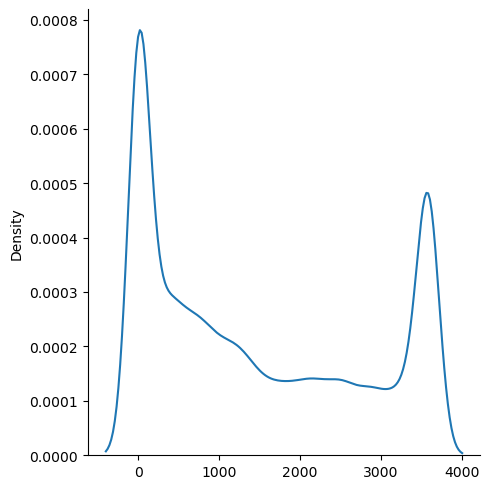

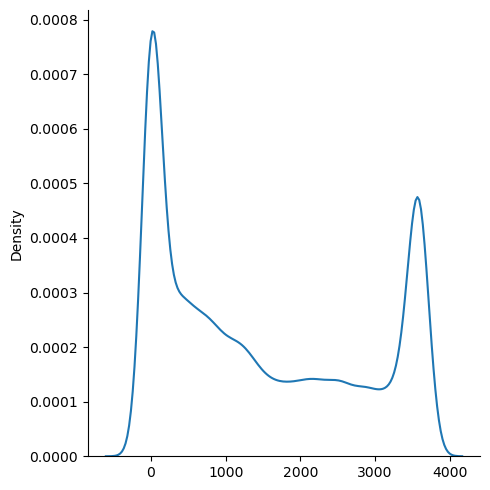

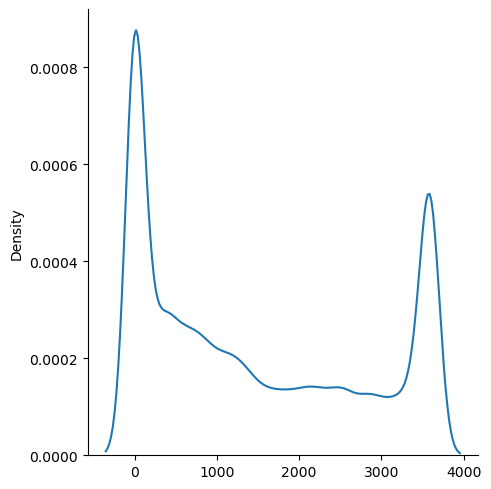

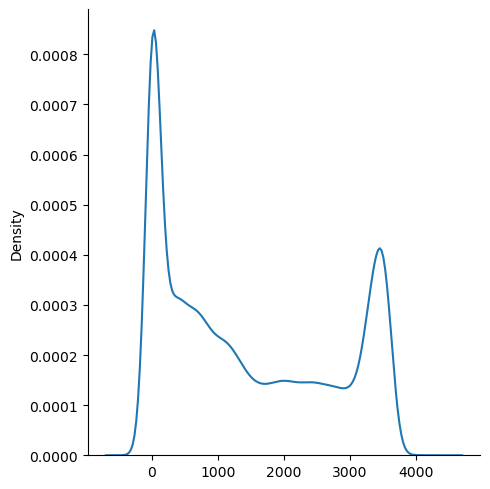

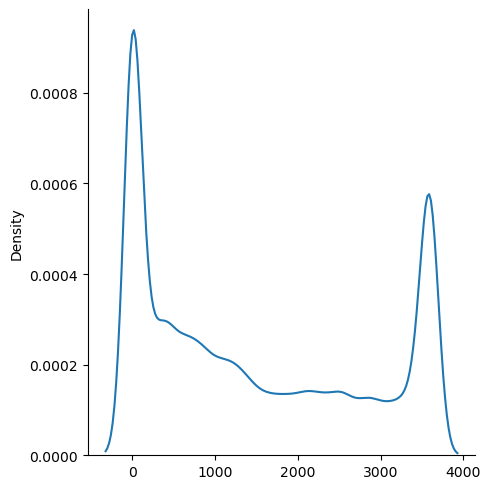

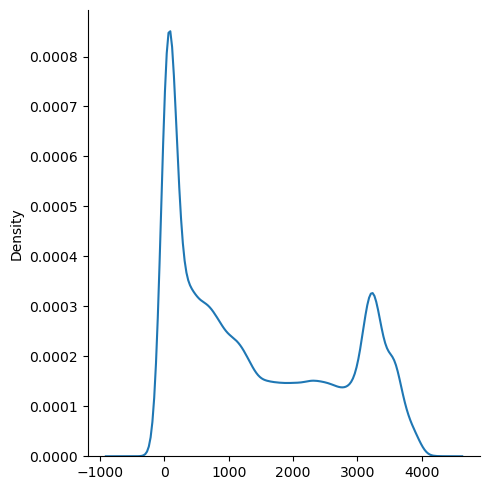

In [12]:
for HORIZON in (10, 20, 30):
    X_uni = df_uni[:-1]
    y_uni = df_uni[1:]
    X_windowed = sliding_window_view(X_uni, WINDOW_SIZE)
    y_uni = sliding_window_view(y_uni, HORIZON)
    X_windowed = X_windowed[:y_uni.shape[0]]
    train_x, train_y, test_x, test_y = make_train_test_splits(X_windowed, y_uni)
    verbose, epochs, batch_size = 1, 20, 16
    # choose a number of time steps
    n_steps = WINDOW_SIZE
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(HORIZON))
    model.compile(optimizer='adam', loss='mse')
    t0 = time.time()
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    t1 = time.time()
    time_elapsed = t1 - t0
    yhat = model.predict(test_x, verbose=verbose)
    yy = yhat.flatten()
    yx = test_y.flatten()
    pred_results = pd.DataFrame()
    pred_results['Actual'] = yx
    pred_results['Predicted'] = yy
    
    model_evals = pd.Series(dtype = np.float64)
    model_evals['SMAPE'] = smape(yx, yy)
    model_evals['RSME'] = mean_squared_error(yx, yy, squared=False)
    model_evals['R2'] = r2_score(yx, yy)
    model_evals['SDE'] = sde(yx, yy)
    model_evals['Bias'] = bias(yx, yy)
    model_evals['Index of Agreement'] = IA(yx, yy)
    model_evals['Processing Time'] = time_elapsed
    model_evals['Losses Accuracy'] = history.history['loss'][-1]
    path = "./univariate/LSTM/Base/"
    
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(path)

    actual_dist = sns.displot(yx, kind='kde')
    pred_dist = sns.displot(yy, kind='kde')
    actual_dist.savefig(f"{path}actual_dist_{HORIZON}.png")
    pred_dist.savefig(f"{path}predicted_dist_{HORIZON}.png")

    model_evals.to_csv(f'{path}Metrics_TH_{HORIZON}.csv')
    pred_results.to_csv(f'{path}Time_Horizon_{HORIZON}.csv')

## Train Using XGBoost Model

[0]	validation_0-rmse:1273.81648	validation_1-rmse:1392.41938
[1]	validation_0-rmse:893.66074	validation_1-rmse:976.85623
[2]	validation_0-rmse:628.01616	validation_1-rmse:686.87646
[3]	validation_0-rmse:442.81843	validation_1-rmse:484.00505
[4]	validation_0-rmse:314.30188	validation_1-rmse:343.25248
[5]	validation_0-rmse:225.87414	validation_1-rmse:246.04550
[6]	validation_0-rmse:165.96834	validation_1-rmse:180.15919
[7]	validation_0-rmse:126.49978	validation_1-rmse:136.64239
[8]	validation_0-rmse:101.52625	validation_1-rmse:109.06318
[9]	validation_0-rmse:86.48780	validation_1-rmse:92.61111
[10]	validation_0-rmse:77.92791	validation_1-rmse:83.32210
[11]	validation_0-rmse:73.21021	validation_1-rmse:78.42640
[12]	validation_0-rmse:70.59601	validation_1-rmse:75.88316
[13]	validation_0-rmse:69.08684	validation_1-rmse:74.60111
[14]	validation_0-rmse:68.15740	validation_1-rmse:74.12225
[15]	validation_0-rmse:67.54864	validation_1-rmse:73.79329
[16]	validation_0-rmse:67.17899	validation_1-r

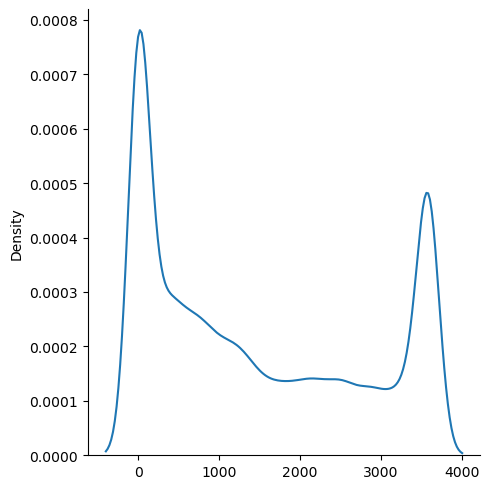

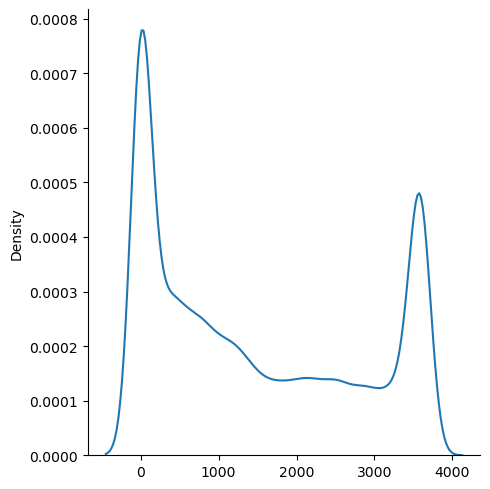

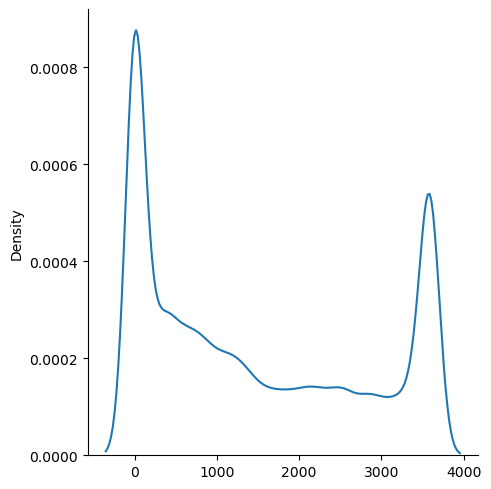

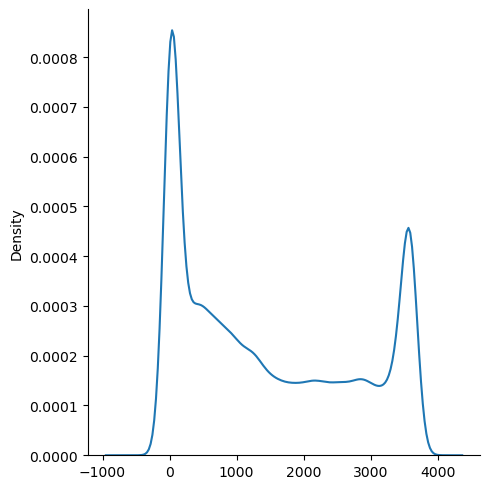

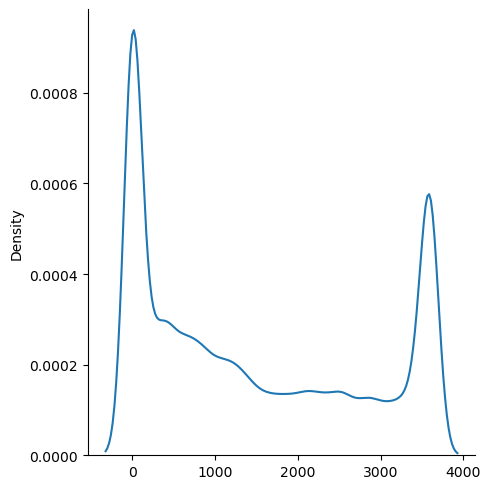

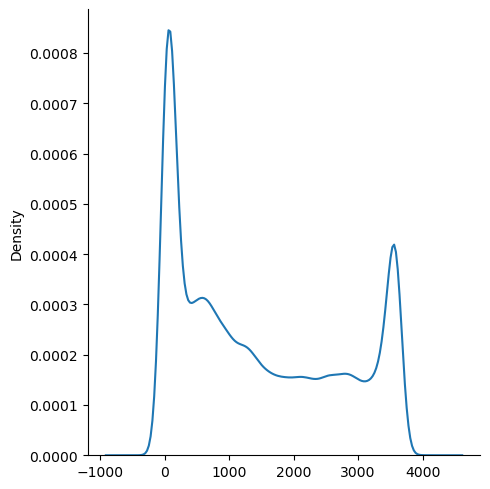

In [13]:
for HORIZON in (10, 20, 30):
    X_uni = df_uni[:-1]
    y_uni = df_uni[1:]
    X_windowed = sliding_window_view(X_uni, WINDOW_SIZE)
    y_uni = sliding_window_view(y_uni, HORIZON)
    X_windowed = X_windowed[:y_uni.shape[0]]
    train_x, train_y, test_x, test_y = make_train_test_splits(X_windowed, y_uni)
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])
    
    evalset = [(train_x, train_y), (test_x,test_y)]
    reg = XGBRegressor(n_estimators=100)
    t0 = time.time()
    reg.fit(train_x, train_y, verbose=True, eval_set = evalset)
    t1 = time.time()
    time_elapsed = t1 - t0
    
    yhat = reg.predict(test_x)
    yy = yhat.flatten()
    yx = test_y.flatten()
    pred_results = pd.DataFrame()
    pred_results['Actual'] = yx
    pred_results['Predicted'] = yy
    
    model_evals = pd.Series(dtype = np.float64)
    model_evals['SMAPE'] = smape(yx, yy)
    model_evals['RSME'] = mean_squared_error(yx, yy, squared=False)
    model_evals['R2'] = r2_score(yx, yy)
    model_evals['SDE'] = sde(yx, yy)
    model_evals['Bias'] = bias(yx, yy)
    model_evals['Index of Agreement'] = IA(yx, yy)
    model_evals['Processing Time'] = time_elapsed
    model_evals['Losses Accuracy'] = reg.evals_result()['validation_0']['rmse'][-1]
    path = "./univariate/XGBOOST/"
    
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(path)

    actual_dist = sns.displot(yx, kind='kde')
    pred_dist = sns.displot(yy, kind='kde')
    actual_dist.savefig(f"{path}actual_dist_{HORIZON}.png")
    pred_dist.savefig(f"{path}predicted_dist_{HORIZON}.png")

    model_evals.to_csv(f'{path}Metrics_TH_{HORIZON}.csv')
    pred_results.to_csv(f'{path}Time_Horizon_{HORIZON}.csv')

## CNN-LSTM

Epoch 1/20
2526/2526 [==============================] - 17s 6ms/step - loss: 82051.1484
Epoch 2/20
2526/2526 [==============================] - 16s 6ms/step - loss: 26851.7559
Epoch 3/20
2526/2526 [==============================] - 16s 6ms/step - loss: 22238.6641
Epoch 4/20
2526/2526 [==============================] - 16s 6ms/step - loss: 41150.4922
Epoch 5/20
2526/2526 [==============================] - 16s 6ms/step - loss: 23626.1172
Epoch 6/20
2526/2526 [==============================] - 16s 6ms/step - loss: 25358.2383
Epoch 7/20
2526/2526 [==============================] - 16s 6ms/step - loss: 17211.5723
Epoch 8/20
2526/2526 [==============================] - 16s 6ms/step - loss: 15502.3623
Epoch 9/20
2526/2526 [==============================] - 16s 6ms/step - loss: 12918.6582
Epoch 10/20
2526/2526 [==============================] - 16s 6ms/step - loss: 11489.4170
Epoch 11/20
2526/2526 [==============================] - 16s 6ms/step - loss: 10516.6953
Epoch 12/20
2526/2526 [=======

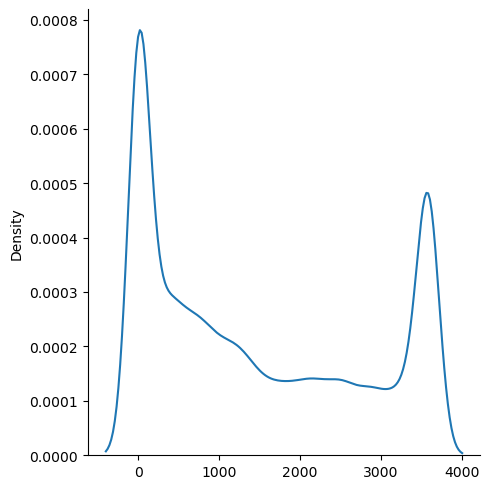

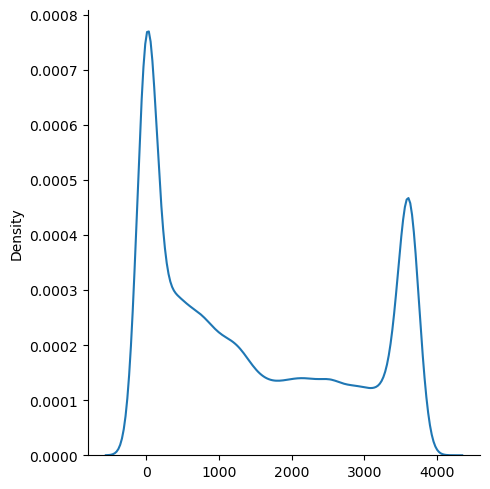

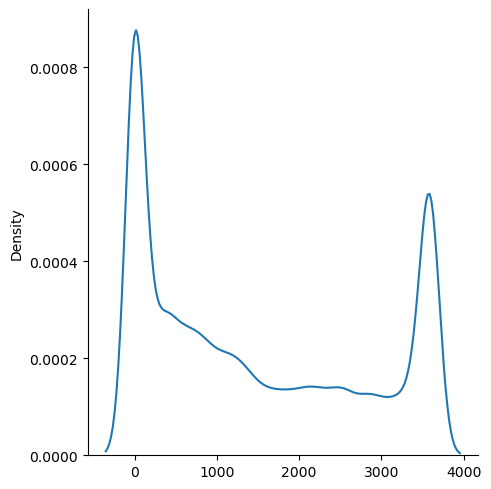

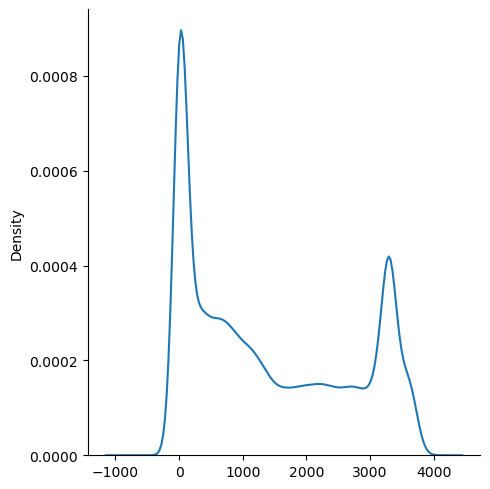

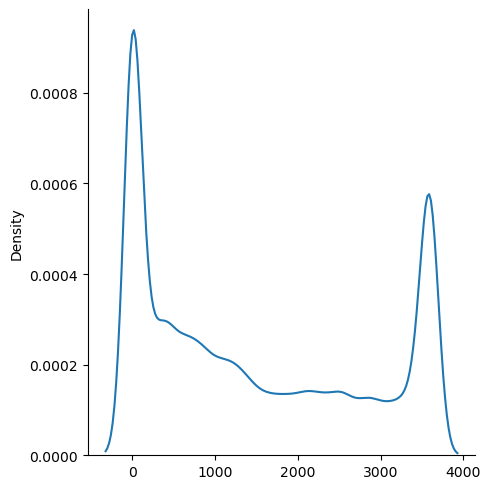

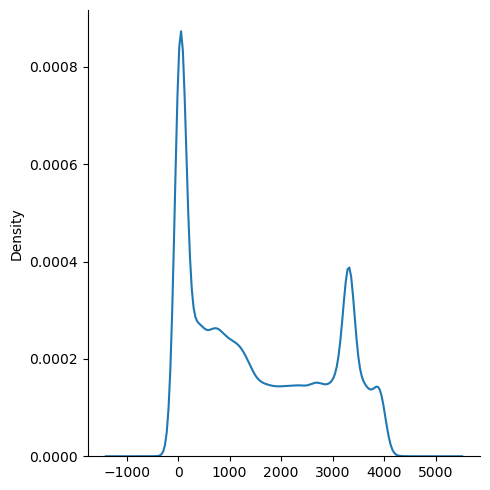

In [14]:
for HORIZON in (10, 20, 30):
    X_uni = df_uni[:-1]
    y_uni = df_uni[1:]
    X_windowed = sliding_window_view(X_uni, WINDOW_SIZE)
    y_uni = sliding_window_view(y_uni, HORIZON)
    X_windowed = X_windowed[:y_uni.shape[0]]
    train_x, train_y, test_x, test_y = make_train_test_splits(X_windowed, y_uni)
    verbose, epochs, batch_size = 1, 20, 16
    # choose a number of time steps
    n_steps = WINDOW_SIZE
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(HORIZON))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    t0 = time.time()
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    t1 = time.time()
    time_elapsed = t1 - t0
    yhat = model.predict(test_x, verbose=verbose)
    yy = yhat.flatten()
    yx = test_y.flatten()
    pred_results = pd.DataFrame()
    pred_results['Actual'] = yx
    pred_results['Predicted'] = yy
    
    model_evals = pd.Series(dtype = np.float64)
    model_evals['SMAPE'] = smape(yx, yy)
    model_evals['RSME'] = mean_squared_error(yx, yy, squared=False)
    model_evals['R2'] = r2_score(yx, yy)
    model_evals['SDE'] = sde(yx, yy)
    model_evals['Bias'] = bias(yx, yy)
    model_evals['Index of Agreement'] = IA(yx, yy)
    model_evals['Processing Time'] = time_elapsed
    model_evals['Losses Accuracy'] = history.history['loss'][-1]
    path = "./univariate/LSTM/CNN/"
    
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(path)

    actual_dist = sns.displot(yx, kind='kde')
    pred_dist = sns.displot(yy, kind='kde')
    actual_dist.savefig(f"{path}actual_dist_{HORIZON}.png")
    pred_dist.savefig(f"{path}predicted_dist_{HORIZON}.png")

    model_evals.to_csv(f'{path}Metrics_TH_{HORIZON}.csv')
    pred_results.to_csv(f'{path}Time_Horizon_{HORIZON}.csv')

### Data Preparation for Multivaraite Dataset

In [15]:
# global variables for window and horizon size
WINDOW_SIZE = 10

Epoch 1/20
2526/2526 [==============================] - 24s 9ms/step - loss: 254801.0156
Epoch 2/20
2526/2526 [==============================] - 20s 8ms/step - loss: 235426.7500
Epoch 3/20
2526/2526 [==============================] - 20s 8ms/step - loss: 229647.8125
Epoch 4/20
2526/2526 [==============================] - 21s 8ms/step - loss: 232513.3125
Epoch 5/20
2526/2526 [==============================] - 21s 8ms/step - loss: 225821.5156
Epoch 6/20
2526/2526 [==============================] - 20s 8ms/step - loss: 238916.7188
Epoch 7/20
2526/2526 [==============================] - 20s 8ms/step - loss: 227106.7500
Epoch 8/20
2526/2526 [==============================] - 21s 8ms/step - loss: 222634.8281
Epoch 9/20
2526/2526 [==============================] - 21s 8ms/step - loss: 225642.1875
Epoch 10/20
2526/2526 [==============================] - 20s 8ms/step - loss: 228710.2344
Epoch 11/20
2526/2526 [==============================] - 20s 8ms/step - loss: 221825.5156
Epoch 12/20
2526/25

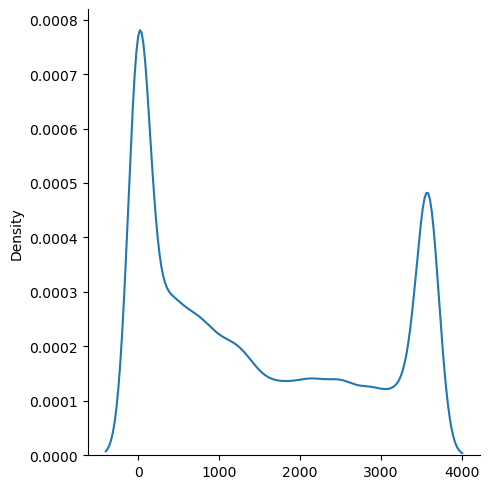

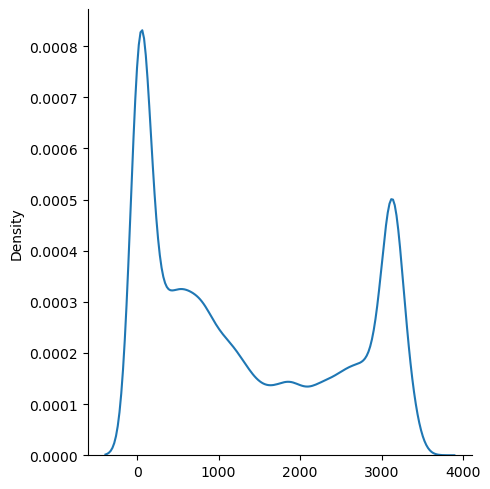

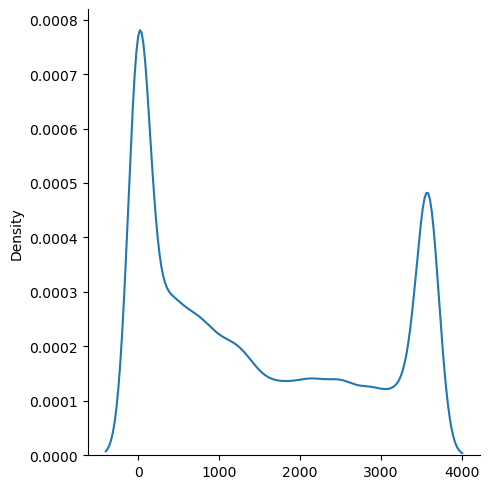

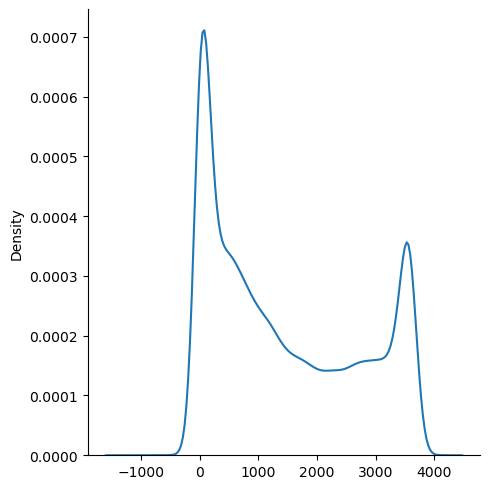

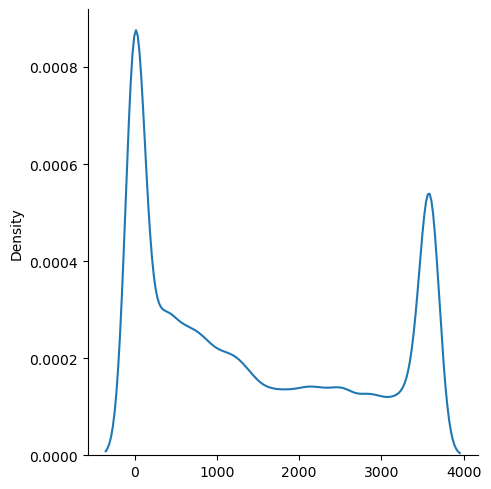

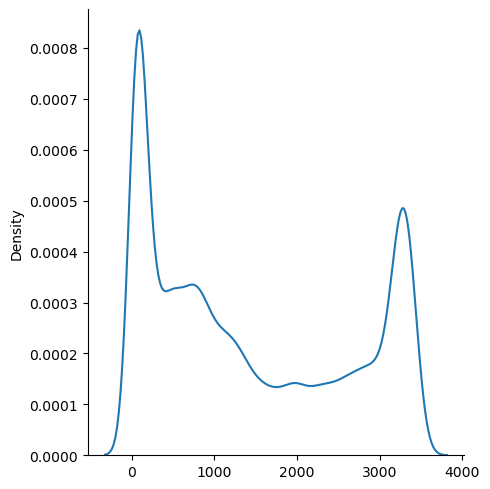

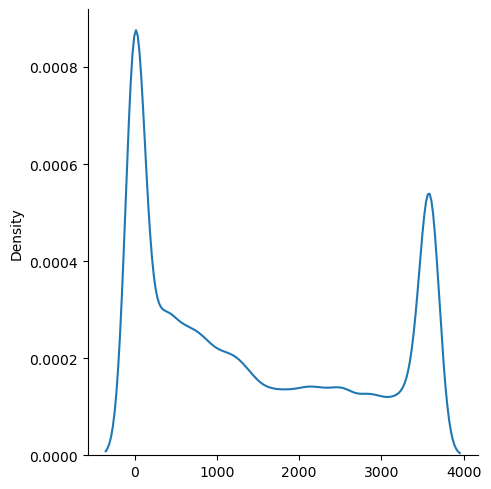

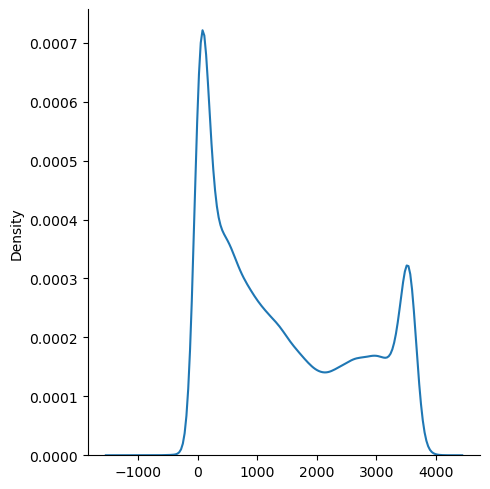

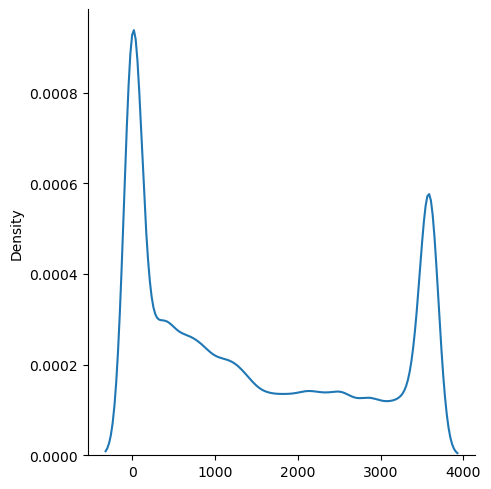

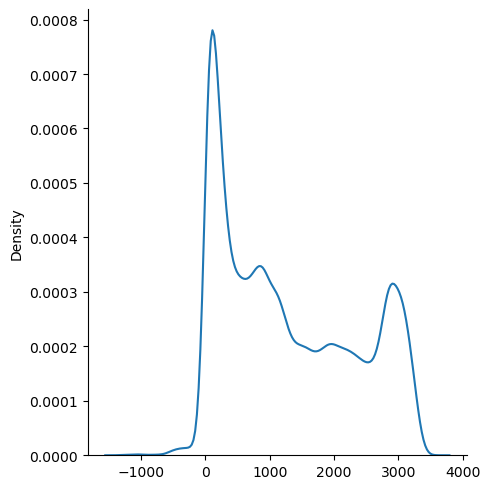

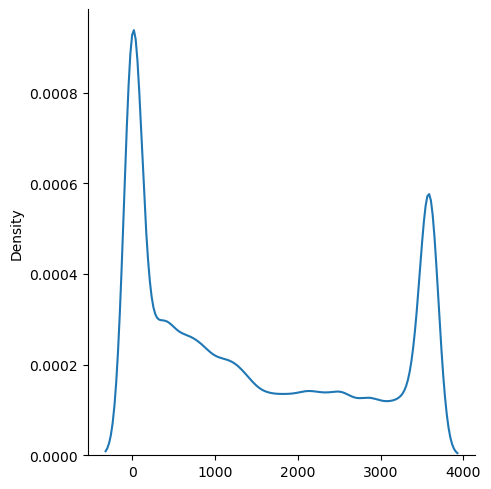

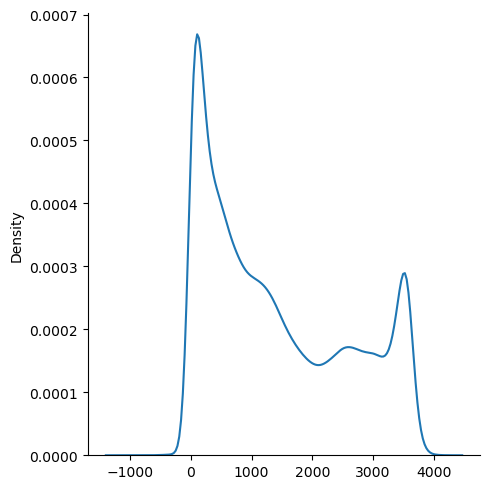

In [17]:
for HORIZON in (10, 20, 30):
    df_windowed = df.copy()
    # Add windowed columns
    for i in range(WINDOW_SIZE): # shift value for each step in WINDOW_SIZE
      df_windowed[f"Power+{i+1}"] = df_windowed["LV ActivePower (kW)"].shift(periods=i+1)
    X = df_windowed.dropna().drop("LV ActivePower (kW)", axis=1).astype(np.float32)
    y = df_windowed.dropna()["LV ActivePower (kW)"].astype(np.float32)
    y_transformed = sliding_window_view(y.to_numpy(), HORIZON)
    X_edited = X[:y_transformed.shape[0]]
    train_x, train_y, test_x, test_y = make_train_test_splits(X_edited.values, y_transformed)
    
    verbose, epochs, batch_size = 1, 20, 16
    # choose a number of time steps
    n_steps = 13
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(HORIZON))
    model.compile(optimizer='adam', loss='mse')
    
    t0 = time.time()
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    t1 = time.time()
    time_elapsed = t1-t0
    
    yhat = model.predict(test_x, verbose=verbose)
    yy = yhat.flatten()
    yx = test_y.flatten()
    pred_results = pd.DataFrame()
    pred_results['Actual'] = yx
    pred_results['Predicted'] = yy
    
    model_evals = pd.Series(dtype = np.float64)
    model_evals['SMAPE'] = smape(yx, yy)
    model_evals['RSME'] = mean_squared_error(yx, yy, squared=False)
    model_evals['R2'] = r2_score(yx, yy)
    model_evals['SDE'] = sde(yx, yy)
    model_evals['Bias'] = bias(yx, yy)
    model_evals['Index of Agreement'] = IA(yx, yy)
    model_evals['Processing Time'] = time_elapsed
    model_evals['Losses Accuracy'] = history.history['loss'][-1]
    path = "./multivariate/LSTM/Base/"
    
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(path)

    actual_dist = sns.displot(yx, kind='kde')
    pred_dist = sns.displot(yy, kind='kde')
    actual_dist.savefig(f"{path}actual_dist_{HORIZON}.png")
    pred_dist.savefig(f"{path}predicted_dist_{HORIZON}.png")

    model_evals.to_csv(f'{path}Metrics_TH_{HORIZON}.csv')
    pred_results.to_csv(f'{path}Time_Horizon_{HORIZON}.csv')
    
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]))
    
    evalset = [(train_x, train_y), (test_x,test_y)]
    reg = XGBRegressor(n_estimators=100)
    t0 = time.time()
    reg.fit(train_x, train_y, verbose=True, eval_set = evalset)
    t1 = time.time()
    time_elapsed = t1-t0
    
    yhat = reg.predict(test_x)
    yy = yhat.flatten()
    yx = test_y.flatten()
    pred_results = pd.DataFrame()
    pred_results['Actual'] = yx
    pred_results['Predicted'] = yy
    
    model_evals = pd.Series(dtype = np.float64)
    model_evals['SMAPE'] = smape(yx, yy)
    model_evals['RSME'] = mean_squared_error(yx, yy, squared=False)
    model_evals['R2'] = r2_score(yx, yy)
    model_evals['SDE'] = sde(yx, yy)
    model_evals['Bias'] = bias(yx, yy)
    model_evals['Index of Agreement'] = IA(yx, yy)
    model_evals['Processing Time'] = time_elapsed
    model_evals['Losses Accuracy'] = reg.evals_result()['validation_0']['rmse'][-1]
    path = "./multivariate/XGBOOST/"
    
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(path)

    actual_dist = sns.displot(yx, kind='kde')
    pred_dist = sns.displot(yy, kind='kde')
    actual_dist.savefig(f"{path}actual_dist_{HORIZON}.png")
    pred_dist.savefig(f"{path}predicted_dist_{HORIZON}.png")

    model_evals.to_csv(f'{path}Metrics_TH_{HORIZON}.csv')
    pred_results.to_csv(f'{path}Time_Horizon_{HORIZON}.csv')
    
    

## ConvLSTM

Epoch 1/20
2526/2526 [==============================] - 21s 8ms/step - loss: 256756.1719
Epoch 2/20
2526/2526 [==============================] - 24s 9ms/step - loss: 227034.7188
Epoch 3/20
2526/2526 [==============================] - 21s 8ms/step - loss: 224948.5781
Epoch 4/20
2526/2526 [==============================] - 20s 8ms/step - loss: 229945.2188
Epoch 5/20
2526/2526 [==============================] - 20s 8ms/step - loss: 222786.5000
Epoch 6/20
2526/2526 [==============================] - 20s 8ms/step - loss: 222734.0625
Epoch 7/20
2526/2526 [==============================] - 20s 8ms/step - loss: 219351.8594
Epoch 8/20
2526/2526 [==============================] - 20s 8ms/step - loss: 219430.5156
Epoch 9/20
2526/2526 [==============================] - 20s 8ms/step - loss: 220583.4375
Epoch 10/20
2526/2526 [==============================] - 20s 8ms/step - loss: 219117.9062
Epoch 11/20
2526/2526 [==============================] - 20s 8ms/step - loss: 218325.0000
Epoch 12/20
2526/25

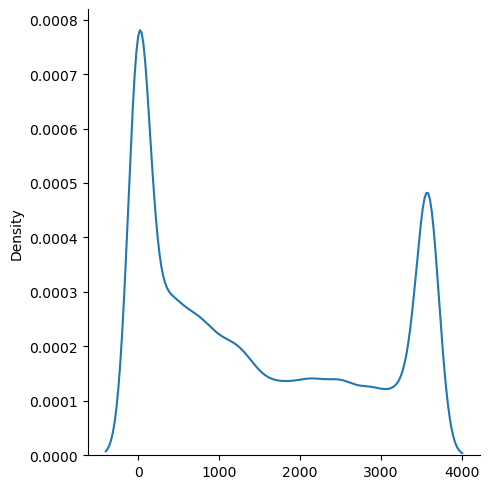

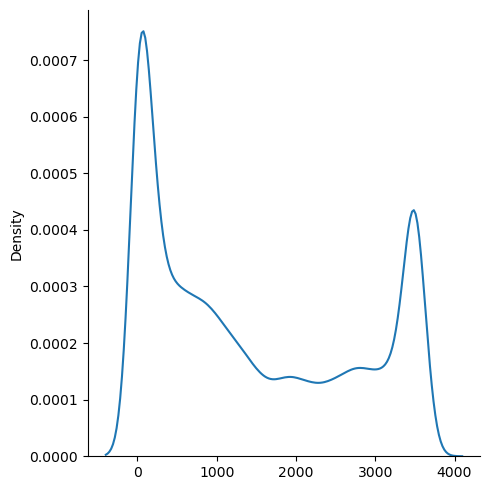

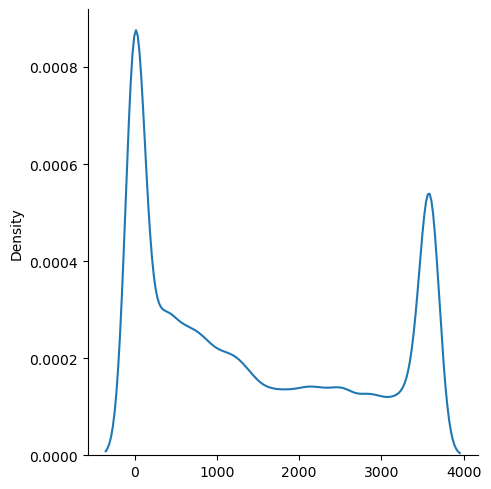

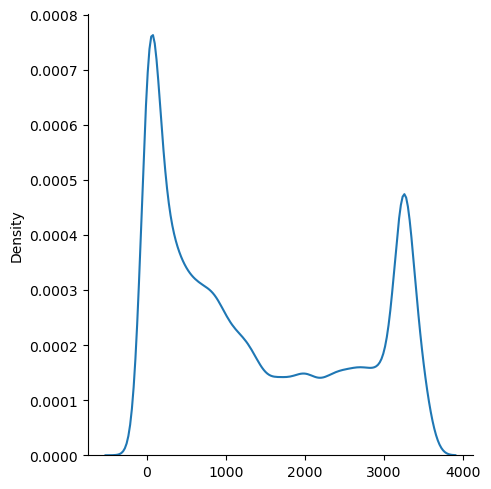

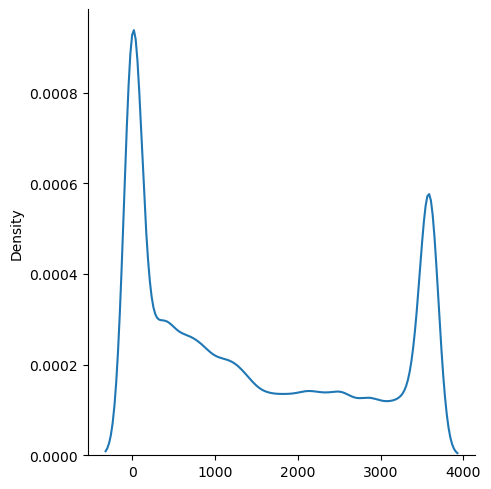

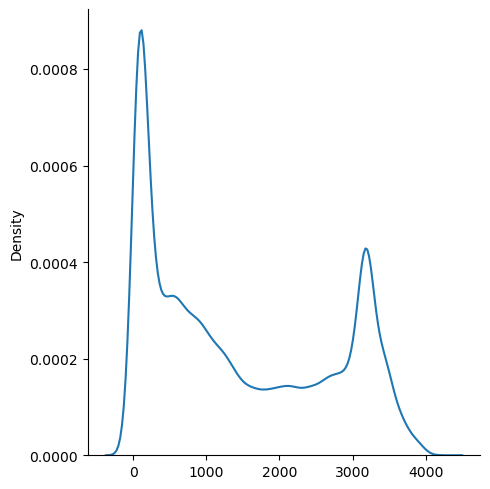

In [18]:
for HORIZON in (10, 20, 30):
    df_windowed = df.copy()
    # Add windowed columns
    for i in range(WINDOW_SIZE): # shift value for each step in WINDOW_SIZE
      df_windowed[f"Power+{i+1}"] = df_windowed["LV ActivePower (kW)"].shift(periods=i+1)
    X = df_windowed.dropna().drop("LV ActivePower (kW)", axis=1).astype(np.float32)
    y = df_windowed.dropna()["LV ActivePower (kW)"].astype(np.float32)
    y_transformed = sliding_window_view(y.to_numpy(), HORIZON)
    X_edited = X[:y_transformed.shape[0]]
    train_x, train_y, test_x, test_y = make_train_test_splits(X_edited.values, y_transformed)
    
    verbose, epochs, batch_size = 1, 20, 16
    # choose a number of time steps
    n_steps = 13
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(HORIZON))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    t0 = time.time()
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    t1 = time.time()
    time_elapsed = t1-t0
    
    yhat = model.predict(test_x, verbose=verbose)
    yy = yhat.flatten()
    yx = test_y.flatten()
    pred_results = pd.DataFrame()
    pred_results['Actual'] = yx
    pred_results['Predicted'] = yy
    
    model_evals = pd.Series(dtype = np.float64)
    model_evals['SMAPE'] = smape(yx, yy)
    model_evals['RSME'] = mean_squared_error(yx, yy, squared=False)
    model_evals['R2'] = r2_score(yx, yy)
    model_evals['SDE'] = sde(yx, yy)
    model_evals['Bias'] = bias(yx, yy)
    model_evals['Index of Agreement'] = IA(yx, yy)
    model_evals['Processing Time'] = time_elapsed
    model_evals['Losses Accuracy'] = history.history['loss'][-1]
    path = "./multivariate/LSTM/CNN/"
    
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(path)

    actual_dist = sns.displot(yx, kind='kde')
    pred_dist = sns.displot(yy, kind='kde')
    actual_dist.savefig(f"{path}actual_dist_{HORIZON}.png")
    pred_dist.savefig(f"{path}predicted_dist_{HORIZON}.png")

    model_evals.to_csv(f'{path}Metrics_TH_{HORIZON}.csv')
    pred_results.to_csv(f'{path}Time_Horizon_{HORIZON}.csv')